**Changing the directory**

In [ ]:
cd '/content/drive/MyDrive/NasrAbadi/Miss-Match detection/StratifiedGroupFold'

/content/drive/.shortcut-targets-by-id/1QjZ52EqSaXzJIHNRgjdB-qbPUcReg_SP/NasrAbadi/Miss-Match detection/StratifiedGroupFold


**Installing Required Packages**

In [ ]:
!pip install scikeras
!pip install pyriemann
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 KB 4.9 MB/s eta 0:00:00


**Loading the data**

In [ ]:
import numpy as np
X = np.load('X.npy')
Y = np.load('Y.npy')

print("X Shape:",X.shape)
print("Y shape:",Y.shape)
print(Y)
import scipy.io
SegmentsPerSubject = scipy.io.loadmat('SegmentsPerSubject', mat_dtype=True)
SegmentsPerSubject = SegmentsPerSubject['SegmentsPerSubject']
SegmentsPerSubject = np.array(SegmentsPerSubject)
SegmentsPerSubject = SegmentsPerSubject.transpose()
print("shape Segments:", SegmentsPerSubject.shape)

Group =[]
for i in range(SegmentsPerSubject.shape[0]):
  for j in range(int(SegmentsPerSubject[i])):
    Group.append(i)
Group = np.array(Group)
Group = np.expand_dims(Group, axis=1)
print(Group)
print("Group shape is:",Group.shape)

X Shape: (7916, 1, 19, 1280)
Y shape: (7916,)
[0 0 0 ... 1 1 1]
shape Segments: (121, 1)
[[  0]
 [  0]
 [  0]
 ...
 [120]
 [120]
 [120]]
Group shape is: (7916, 1)


**Change the channels to first**

In [ ]:
from tensorflow.keras import backend as K
K.set_image_data_format('channels_first')

**Building the Model**

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import utils as np_utils
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import fbeta_score
import math
import gc
from numpy import mean
from numpy import std
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import cross_val_score

def create_model(kernelLength = 32, nb_classes = 1, Chans = 19, Samples = 1280, 
            dropoutRate = 0.5 , F1 = 8, 
            D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
  
  K.clear_session()
  gc.collect()
  if dropoutType == 'SpatialDropout2D':
      dropoutType = SpatialDropout2D
  elif dropoutType == 'Dropout':
      dropoutType = Dropout
  else:
      raise ValueError('dropoutType must be one of SpatialDropout2D '
                        'or Dropout, passed as a string.')
  
  input1   = Input(shape = (1, Chans, Samples))

  ##################################################################
  block1       = Conv2D(F1, (1, kernelLength), padding = 'same',
                                  input_shape = (1, Chans, Samples),
                                  use_bias = False)(input1)
  block1       = BatchNormalization(axis = 1)(block1)
  block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                  depth_multiplier = D,
                                  depthwise_constraint = max_norm(1.))(block1)
  block1       = BatchNormalization(axis = 1)(block1)
  block1       = Activation('elu')(block1)
  block1       = AveragePooling2D((1, 4))(block1)
  block1       = dropoutType(dropoutRate)(block1)
  
  block2       = SeparableConv2D(F2, (1, 16),
                                  use_bias = False, padding = 'same')(block1)
  block2       = BatchNormalization(axis = 1)(block2)
  block2       = Activation('elu')(block2)
  block2       = AveragePooling2D((1, 8))(block2)
  block2       = dropoutType(dropoutRate)(block2)
      
  flatten      = Flatten(name = 'flatten')(block2)
  
  dense        = Dense(nb_classes, name = 'dense', 
                        kernel_constraint = max_norm(norm_rate))(flatten)
  sigmoid      = Activation('sigmoid', name = 'sigmoid')(dense)
  
  model        = Model(inputs=input1, outputs=sigmoid)
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
  return model

**Calculating the accuracy and F-measure for each subject**

In [ ]:
def subject_classification(y_true, y_pred, group, calculate_type = 'max_vote'):  
  """
  y_pred should be the output of 'model.predict' using 2 nodes in the dense layer and softmax activation.
  """
  from pyriemann.utils.viz import plot_confusion_matrix
  from sklearn.metrics import fbeta_score
  probability = np.array(y_pred)
  prediction = y_pred.argmax(axis = -1)
  max_vote = []
  subject_traget = []
  j = 0
  unique, counts = np.unique(group, return_counts=True)
  mean_ = np.zeros([len(unique),2], dtype='float32')
  for i in range(len(unique)):
    for k in range(2):
      mean_[i][k] = np.mean(probability[j:j+counts[i]-1,k])
    c = np.bincount(prediction[j:j+counts[i]-1])
    max_vote.append(np.argmax(c))
    subject_traget.append(y_true[j])
    j = j + counts[i]
  mean_       = mean_.argmax(axis = -1)
  max_vote = np.array(max_vote)
  subject_traget = np.array(subject_traget)
  f2_max_vote      = fbeta_score(subject_traget, max_vote, beta=0.5, average='binary')
  f2_mean          = fbeta_score(subject_traget, mean_, beta=0.5, average='binary')
  acc_max_vote     = np.mean(max_vote == subject_traget)
  acc_mean         = np.mean(mean_ == subject_traget)
  if calculate_type == 'max_vote':
    names        = ['ADHD','Control']
    plt.figure(0)
    plot_confusion_matrix(subject_traget, max_vote, names, title = 'Max Vote Type')
    return acc_max_vote, f2_max_vote
  elif calculate_type == 'mean':
    names        = ['ADHD','Control']
    plt.figure(0)
    plot_confusion_matrix(subject_traget, mean_, names, title = 'Mean Type')
    return acc_mean, f2_mean
  else:
    raise ValueError('You have NOT entered an accurate type!')

**Spliting the early stopping and test dataset**

In [ ]:
group_kfold1 = StratifiedGroupKFold(n_splits=10, shuffle=True, random_state=2022)
# Test split ....
split_test = group_kfold1.split(X,Y,Group)
d_test = next(split_test)
X_tr = X[d_test[0]]
Y_tr = Y[d_test[0]]
X_test = X[d_test[1]]
Y_test = Y[d_test[1]]
Group_tr = Group[d_test[0]]
Group_test = Group[d_test[1]]
# Early stopping split ...
group_kfold2 = StratifiedGroupKFold(n_splits=18, shuffle=True, random_state=2022)
split_early = group_kfold2.split(X_tr,Y_tr,Group_tr)
d_early = next(split_early)
X_train = X_tr[d_early[0]]
Y_train = Y_tr[d_early[0]]
X_early = X_tr[d_early[1]]
Y_early = Y_tr[d_early[1]]
Group_train = Group_tr[d_early[0]]
Group_early = Group_tr[d_early[1]]

del X,Y,X_tr,Y_tr, d_early,split_early,d_test, split_test, Group, Group_tr

**Computing the Class Weight**

In [ ]:
### Compute Class_weight ###
def ClassWeight(y):
  class_weights = compute_class_weight(class_weight = "balanced",classes = np.unique(y), y = y)
  class_weights = dict(zip(np.unique(y), class_weights))
  class_weights[0] = int(10*round(class_weights[0],1))
  class_weights[1] = int(10*round(class_weights[1],1))
  class_weight = class_weights
  print("The Class Weight is:",class_weight)
  return class_weight
class_weight = ClassWeight(Y_train)

The Class Weight is: {0: 9, 1: 11}


In [ ]:
print("X_train shape:",X_train.shape)
print("X_early shape:",X_early.shape)
print("X_test shape:",X_test.shape)
print("----------------------------")
print("Y_train shape:",Y_train.shape)
print("Y_early shape:",Y_early.shape)
print("Y_test shape:",Y_test.shape)
print('----------------------------')
print("Group_train shape:",Group_train.shape)
print("Group_early shape:",Group_early.shape)
print("Group_test shape:",Group_test.shape)

X_train shape: (6699, 1, 19, 1280)
X_early shape: (504, 1, 19, 1280)
X_test shape: (713, 1, 19, 1280)
----------------------------
Y_train shape: (6699,)
Y_early shape: (504,)
Y_test shape: (713,)
----------------------------
Group_train shape: (6699, 1)
Group_early shape: (504, 1)
Group_test shape: (713, 1)


**Defining the Bayesian Optimization using the search space and defined model**

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
callbacks = [es]
# KerasClassifier Defining 

model = KerasClassifier(model=create_model, verbose = 2,shuffle=True,
                        epochs=100,batch_size=32,fit__validation_data =(X_early, Y_early),
                        class_weight=class_weight,callbacks=callbacks)
#Search space
search_space = {'model__F1': Categorical([8, 16]),
                'model__F2': Categorical([16, 32]),
                'model__kernelLength': Categorical([32, 64, 128, 256, 512]),
                'model__norm_rate': Categorical([0.5, 1.0, 5.0, 10.0])}

search = BayesSearchCV(estimator=model, search_spaces=search_space,
                       n_iter=10,cv=5, n_jobs=1, verbose=True)

**Fitting the model to find the optimal hyper-parameters**

In [ ]:
search_result = search.fit(X_train, y=Y_train, groups=Group_train)
means = search_result.cv_results_['mean_test_score']
stds = search_result.cv_results_['std_test_score']
params = search_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print("The Best Score:",search.best_score_)
print("The Best Params:",search.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Epoch 1/100
168/168 - 13s - loss: 4.5206 - accuracy: 0.7832 - val_loss: 0.6826 - val_accuracy: 0.5893 - 13s/epoch - 74ms/step
Epoch 2/100
168/168 - 3s - loss: 1.4693 - accuracy: 0.9472 - val_loss: 1.3214 - val_accuracy: 0.5417 - 3s/epoch - 16ms/step
Epoch 3/100
168/168 - 3s - loss: 0.7936 - accuracy: 0.9711 - val_loss: 1.2181 - val_accuracy: 0.5655 - 3s/epoch - 16ms/step
Epoch 4/100
168/168 - 3s - loss: 0.4201 - accuracy: 0.9871 - val_loss: 1.1296 - val_accuracy: 0.5972 - 3s/epoch - 17ms/step
Epoch 5/100
168/168 - 3s - loss: 0.3315 - accuracy: 0.9890 - val_loss: 2.0124 - val_accuracy: 0.5337 - 3s/epoch - 17ms/step
Epoch 6/100
168/168 - 3s - loss: 0.3906 - accuracy: 0.9877 - val_loss: 1.4974 - val_accuracy: 0.5556 - 3s/epoch - 17ms/step
Epoch 7/100
168/168 - 3s - loss: 0.2188 - accuracy: 0.9938 - val_loss: 0.7898 - val_accuracy: 0.8095 - 3s/epoch - 17ms/step
Epoch 8/100
168/168 - 3s - loss: 0.1859 - accuracy: 0.9942 - val_loss: 

**Predicting and evaluating on the test set(sample-wise and subject-wise)**

23/23 - 0s - 130ms/epoch - 6ms/step
The sample test acc is: 0.8387096774193549
23/23 - 0s - 124ms/epoch - 5ms/step
Subject Accuracy MaxVote: 0.8333333333333334
Subject F2 MaxVote: 0.7575757575757576
------------------------------
Subject Accuracy Mean: 0.8333333333333334
Subject F2 Mean: 0.7575757575757576


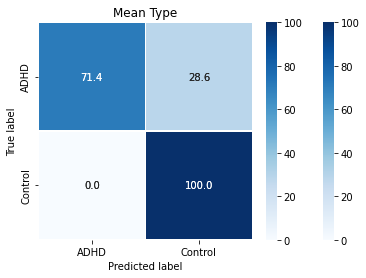

In [ ]:
#### Test Prediction ####
pred = search.predict(X_test)
acc  = np.mean(pred == Y_test)
print("The sample test acc is:", acc)
### Calculate Subject accuracy and F-measure
pred_proba = search.predict_proba(X_test)
sub_acc_max , subF2_max = subject_classification(Y_test, pred_proba, Group_test, calculate_type = 'max_vote')
print("Subject Accuracy MaxVote:",sub_acc_max)
print("Subject F2 MaxVote:",subF2_max)
print("------------------------------")
sub_acc_mean , subF2_mean = subject_classification(Y_test, pred_proba, Group_test, calculate_type = 'mean')
print("Subject Accuracy Mean:",sub_acc_mean)
print("Subject F2 Mean:",subF2_mean)